# Step.2 KGB(known Good/Bad)训练，用于检测拒绝集(训练集中的unknown标签)

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import atecml.data
from tqdm import tqdm

class BasicModel(object):
    """Parent class of basic models"""
    def train(self, x_train, y_train, x_val, y_val):
        """return a trained model and eval metric o validation data"""
        pass
    
    def predict(self, model, x_test):
        """return the predicted result"""
        pass
    
    def get_oof(self, x_train, y_train, x_test, n_folds = 5):
        """K-fold stacking"""
        num_train, num_test = x_train.shape[0], x_test.shape[0]
        oof_train = np.zeros((num_train,)) 
        oof_test = np.zeros((num_test,))
        oof_test_all_fold = np.zeros((num_test, n_folds))
        aucs = []
        model_list = []
        
        for i in range(0,n_folds):
            
            val_index = DateFold[5] #始终用最后20%验证            
            train_index = list(all_list - DateFold[i])
                            
            print('{0} fold, train {1}, val {2}'.format(i, len(train_index), len(val_index)))
            x_tra, y_tra = x_train[train_index], y_train[train_index]
            x_val, y_val = x_train[val_index], y_train[val_index]
            
            #Over_sample
            #X_resampled, y_resampled = SMOTE().fit_sample(x_tra,y_tra)
            #model, auc = self.train(X_resampled, y_resampled, x_val, y_val)
            model, auc = self.train(x_tra, y_tra, x_val, y_val)
            aucs.append(auc)
            model_list.append(model)
            oof_train[val_index] = self.predict(model, x_val)
            oof_test_all_fold[:, i] = self.predict(model, x_test)
        oof_test = np.mean(oof_test_all_fold, axis=1)
        print('all aucs {0}, average {1}'.format(aucs, np.mean(aucs)))
        return oof_train, oof_test,model_list

import lightgbm as lgb
class LGBClassifier(BasicModel):
    '''
    ' 调参范围
    'num_leaves':range(35,65,5)
    'learning_rate':[0.01,0.05,0.1,0.3,0.5,0.7]
    'min_child_weight':range(1,6,2)
    'max_depth':range(3,10,2),
    'subsample':[i/10.0 for i in range(6,10)],正常直接设置为1
    'colsample_bytree':[i/10.0 for i in range(6,10)]，正常直接设置为1
    'reg_alpha','reg_lambda':[1e-5, 1e-2, 0.1, 1, 2,2.5,3]
    '''
    def __init__(self,boost_type,boost_round=1000,early_stop=100,pos_weight=1):
        self.num_boost_round = boost_round
        self.early_stopping_rounds = early_stop
        self.params = {
            'task': 'train',
            'boosting_type': boost_type,
            'colsample_bytree': 0.7,
            'learning_rate': 0.05,
            'max_bin': 255,
            'max_depth': -1,
            'metric': {'auc'},
            'min_child_samples': 600,
            'min_child_weight': 0.05,
            'min_split_gain': 0,
            'nthread': 40,
            'num_leaves': 80,
            'objective': 'binary',
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            #'is_unbalance':'true',
            'scale_pos_weight': pos_weight,
            'subsample': 0.85,
            'subsample_for_bin': 200000,
            'subsample_freq': 1,
            'use_missing': 'true',
            'verbose' : -1,
            }
        print(self.params)
        
    def train(self, x_train, y_train, x_val, y_val):
        print('train with lgb model')
        lgbtrain = lgb.Dataset(x_train, y_train)
        lgbval = lgb.Dataset(x_val, y_val)
        model = lgb.train(self.params, 
                          lgbtrain,
                          valid_sets=lgbval, 
                          verbose_eval = 50,
                          num_boost_round = self.num_boost_round,
                          early_stopping_rounds = self.early_stopping_rounds)
        return model, model.best_score['valid_0']['auc']
    
    def predict(self, model, x_test):
        print('test with lgb model')
        return model.predict(x_test, num_iteration=model.best_iteration)

def stack_layer1_result(X_train,rf_model_list,gbdt_model_list,dart_model_list):
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        rf_input_list = []
        for idx in tqdm(range(len(rf_model_list))):
            model = rf_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            rf_input_list.append(pd.DataFrame(_temp_df))
        rf_oof_predict= np.array(pd.concat(rf_input_list,ignore_index=True,axis=1).mean(axis=1))    
    
        gbdt_input_list = []
        for idx in tqdm(range(len(gbdt_model_list))):
            model = gbdt_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            gbdt_input_list.append(pd.DataFrame(_temp_df))
        gbdt_oof_predict= np.array(pd.concat(gbdt_input_list,ignore_index=True,axis=1).mean(axis=1))
        
        
        dart_input_list = []
        for idx in tqdm(range(len(dart_model_list))):
            model = dart_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            dart_input_list.append(pd.DataFrame(_temp_df))
        dart_oof_predict= np.array(pd.concat(dart_input_list,ignore_index=True,axis=1).mean(axis=1))
    
    input_predict = [rf_oof_predict, gbdt_oof_predict, dart_oof_predict] 
    stacked_predict = np.concatenate([f.reshape(-1, 1) for f in input_predict], axis=1)
    
    return stacked_predict

def stack_layer1_result_wo_rf(X_train,rf_model_list,gbdt_model_list,dart_model_list):
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        predict_list = []
    
        gbdt_input_list = []
        for idx in tqdm(range(len(gbdt_model_list))):
            model = gbdt_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            predict_list.append(_temp_df)
            gbdt_input_list.append(pd.DataFrame(_temp_df))
        gbdt_oof_predict= np.array(pd.concat(gbdt_input_list,ignore_index=True,axis=1).mean(axis=1))
        
        
        dart_input_list = []
        for idx in tqdm(range(len(dart_model_list))):
            model = dart_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            predict_list.append(_temp_df)
            dart_input_list.append(pd.DataFrame(_temp_df))
        dart_oof_predict= np.array(pd.concat(dart_input_list,ignore_index=True,axis=1).mean(axis=1))
    
    #input_predict = [ gbdt_oof_predict, dart_oof_predict] 
    input_predict = predict_list
    stacked_predict = np.concatenate([f.reshape(-1, 1) for f in input_predict], axis=1)
    
    return stacked_predict


In [3]:
train_df = pd.read_pickle('./train_new.dat')
val_df = pd.read_pickle('./test_new.dat')
target = 'Fraud'

predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]

DateFold_DF = {}
DateFold_DF[0] = atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12')
DateFold_DF[1] = atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20')
DateFold_DF[2] = atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28')
DateFold_DF[3] = atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06')
DateFold_DF[4] = atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14')
DateFold_DF[5] = atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24')


DateFold={}

DateFold[0] = set(DateFold_DF[0].index)
DateFold[1] = set(DateFold_DF[1].index)
DateFold[2] = set(DateFold_DF[2].index)
DateFold[3] = set(DateFold_DF[3].index)
DateFold[4] = set(DateFold_DF[4].index)
DateFold[5] = list(DateFold_DF[4].index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])

x_train = np.array(train_df[predictors])
y_train = np.array(train_df[target])
x_test = np.array(val_df[predictors])
print(x_train.shape, y_train.shape, x_test.shape)

(994731, 480) (994731,) (500538, 480)


In [ ]:
i = 1

In [3]:
num_pos = np.sum(train_df[target])  
num_neg = x_train.shape[0]- num_pos
scale_pos_weight =  num_neg/num_pos
print(num_pos,num_neg,scale_pos_weight)

13189.0 981542.0 74.42126014102661


In [4]:
num_boost_round = 2500
num_early_stop = 100

In [5]:
# get output of first layer models and construct as input for the second layer          
rf_classifier = LGBClassifier(boost_type='rf',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
rf_oof_train, rf_oof_test,rf_model_list = rf_classifier.get_oof(x_train, y_train, x_test)
print(rf_oof_train.shape, rf_oof_test.shape)  


{'subsample_freq': 1, 'boosting_type': 'rf', 'nthread': 40, 'subsample': 0.85, 'min_child_samples': 600, 'min_split_gain': 0, 'reg_lambda': 0.1, 'num_leaves': 80, 'max_bin': 255, 'task': 'train', 'min_child_weight': 0.05, 'learning_rate': 0.05, 'scale_pos_weight': 74.42126014102661, 'metric': {'auc'}, 'max_depth': -1, 'colsample_bytree': 0.7, 'subsample_for_bin': 200000, 'use_missing': 'true', 'reg_alpha': 0.1, 'objective': 'binary', 'verbose': -1}
0 fold, train 500685, val 360447
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.9737
[100]	valid_0's auc: 0.973563
Early stopping, best iteration is:
[7]	valid_0's auc: 0.976509
test with lgb model
test with lgb model
1 fold, train 509423, val 360447
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.97354
[100]	valid_0's auc: 0.972971
Early stopping, best iteration is:
[33]	valid_0's auc: 0.974172
test with lgb model
test with l

In [6]:
gbdt_classifier = LGBClassifier(boost_type='gbdt',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
gbdt_oof_train, gbdt_oof_test,gbdt_model_list = gbdt_classifier.get_oof(x_train, y_train, x_test)
print(gbdt_oof_train.shape, gbdt_oof_test.shape)  

dart_classifier = LGBClassifier(boost_type='dart',boost_round=num_boost_round,early_stop=num_early_stop,pos_weight= scale_pos_weight)
dart_oof_train, dart_oof_test,dart_model_list = dart_classifier.get_oof(x_train, y_train, x_test)
print(dart_oof_train.shape, dart_oof_test.shape)    

{'subsample_freq': 1, 'boosting_type': 'gbdt', 'nthread': 40, 'subsample': 0.85, 'min_child_samples': 600, 'min_split_gain': 0, 'reg_lambda': 0.1, 'num_leaves': 80, 'max_bin': 255, 'task': 'train', 'min_child_weight': 0.05, 'learning_rate': 0.05, 'scale_pos_weight': 74.42126014102661, 'metric': {'auc'}, 'max_depth': -1, 'colsample_bytree': 0.7, 'subsample_for_bin': 200000, 'use_missing': 'true', 'reg_alpha': 0.1, 'objective': 'binary', 'verbose': -1}
0 fold, train 500685, val 360447
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.979619
[100]	valid_0's auc: 0.982371
[150]	valid_0's auc: 0.98345
[200]	valid_0's auc: 0.983959
[250]	valid_0's auc: 0.984081
[300]	valid_0's auc: 0.983992
Early stopping, best iteration is:
[236]	valid_0's auc: 0.984196
test with lgb model
test with lgb model
1 fold, train 509423, val 360447
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.978223

In [11]:
stacked_train = stack_layer1_result_wo_rf(x_train,rf_model_list,gbdt_model_list,dart_model_list)
stacked_test = stack_layer1_result_wo_rf(x_test,rf_model_list,gbdt_model_list,dart_model_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-03 18:57:26][Classification: Building Layer-1 Stack] Begin ...


100%|██████████| 5/5 [01:10<00:00, 14.06s/it]


[2018-07-03 18:59:33][Classification: Building Layer-1 Stack] End   ...[Elapsed: 127.34s]


  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-03 18:59:33][Classification: Building Layer-1 Stack] Begin ...


100%|██████████| 5/5 [00:30<00:00,  6.11s/it]

[2018-07-03 19:00:27][Classification: Building Layer-1 Stack] End   ...[Elapsed: 53.57s]


Ant-Score: 0.4671388101983003


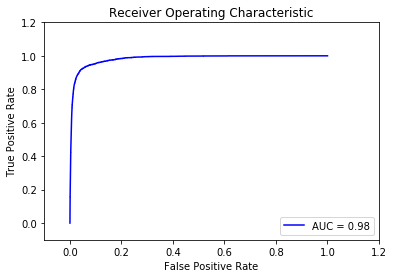

In [12]:
# use XGBOOST  as the model of the second layer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=200,
 max_depth=3,
 min_child_weight=1,
 gamma=1,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 scale_pos_weight= scale_pos_weight,
 nthread=40,
 seed=27)


# split for validation
n = int(stacked_train.shape[0] * 0.8)
x_tra, y_tra = stacked_train[:n], y_train[:n]
x_val, y_val = stacked_train[n:], y_train[n:]
model.fit(x_tra,y_tra)
y_pred = pd.DataFrame(model.predict_proba(x_val))[1]

_f1,_f2,_f3 = atecml.data.accuracy_validation(y_val,y_pred)

In [13]:
# predict on test data
final_model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=200,
 max_depth=3,
 min_child_weight=1,
 gamma=1,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 scale_pos_weight= scale_pos_weight,    
 nthread=40,
 seed=27)


final_model.fit(stacked_train, y_train)
test_prediction = final_model.predict_proba(stacked_test)

result=pd.DataFrame()
result['id'] = val_df['id']
result['score'] = pd.DataFrame(test_prediction)[1]


In [14]:
result.to_csv('./submit_2018_07_03_1800.csv',index=False)

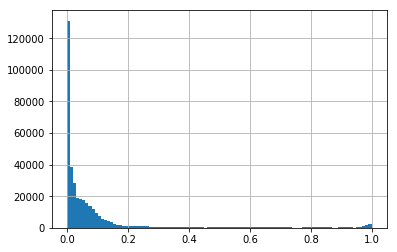

In [15]:
result[result.score > 0.001]['score'].hist(bins=100)

In [16]:
result

,id,score
0,661ae9a03c6c74feab2555c9987e140ae3f5421bd8e7a0...,0.000680
1,ada98d4358e72a27cc5e92f691a87a4fd62a7cda0387e2...,0.000556
2,e33675a962e5bf44d05a2b01903a4beb88a0c6385c05c6...,0.006990
3,4c5da176de7172dbd1ad0aa7edf9866548ec720d6c7318...,0.010748
4,fa39e3491900d49b862d30b5dbcd0b1c30bb4ff0d96396...,0.036123
5,ae0f1ecb27e098bbf672529a50237dff27abd16b349569...,0.000251
6,7a9e5e415412a92928f91608c39750e3a33eb123eb0ef8...,0.000323
7,51fb55256e959c36989151e8136a8a68002bb75887eb75...,0.029097
8,aa7664463d11ae5573ae6d89195373fbe033c354710142...,0.042136
9,b794af5790f98806ff8ad8ee268caa606dffcfbcb753bd...,0.003241
